# Import all Libraries

In [8]:
# Verify all libraries are imported
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
from collections import Counter
import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

# Specific imports for MobileNetV2 and ResNet50 only
from torchvision.models import mobilenet_v2, resnet50
from torchvision.models import MobileNet_V2_Weights, ResNet50_Weights
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

print("✅ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 Available GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
print("🎯 Random seeds set for reproducibility")

# Display available models
print("\n🤖 Available Models:")
print("   - MobileNetV2")
print("   - ResNet50")

✅ All libraries imported successfully!
PyTorch version: 2.9.0+cu126
🚀 Using device: cuda
🎮 GPU: Tesla T4
💾 Available GPU memory: 14.7 GB
🎯 Random seeds set for reproducibility

🤖 Available Models:
   - MobileNetV2
   - ResNet50


In [ ]:
!pip install -q kaggle

from google.colab import files
files.upload()   # ⬅️ Upload your kaggle.json here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"moneebmushtaq","key":"56f7365674f32bfb69c16a1f1022c5b7"}'}

In [9]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [11]:
!kaggle datasets download -d salmansajid05/oral-diseases -p /content


Dataset URL: https://www.kaggle.com/datasets/salmansajid05/oral-diseases
License(s): unknown
 95% 222M/235M [00:00<00:00, 693MB/s] 
100% 235M/235M [00:00<00:00, 722MB/s]


In [12]:
!unzip -o -q /content/oral-diseases.zip -d /content/oral_diseases

# Correct Dataset Paths Setup

In [13]:
import os
from pathlib import Path

def discover_dataset_structure(base_path):
    base_path = Path(base_path)
    print("🔍 Discovering dataset structure...\n")

    all_images = {}

    for root, dirs, files in os.walk(base_path):
        root_path = Path(root)
        image_files = [
            f for f in files
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]

        if image_files:
            category_name = root_path.relative_to(base_path)
            all_images[str(category_name)] = {
                'path': root_path,
                'image_count': len(image_files),
                'sample_files': image_files[:3]
            }
            print(f"✅ {category_name} → {len(image_files)} images")

    return all_images


# Run Discovery
dataset_path = "/content/oral_diseases"
dataset_structure = discover_dataset_structure(dataset_path)

print(f"\n📊 Total folders found: {len(dataset_structure)}\n")
for category, info in dataset_structure.items():
    print(f"📁 {category}: {info['image_count']} images")


🔍 Discovering dataset structure...

✅ hypodontia/hypodontia → 1251 images
✅ Mouth Ulcer/Mouth Ulcer/ulcer original dataset/ulcer original dataset → 265 images
✅ Mouth Ulcer/Mouth Ulcer/Mouth_Ulcer_augmented_DataSet/preview → 2541 images
✅ Calculus/Calculus → 1296 images
✅ Gingivitis/Gingivitis → 2349 images
✅ Tooth Discoloration/Tooth Discoloration /tooth discoloration original dataset/tooth discoloration original dataset → 183 images
✅ Tooth Discoloration/Tooth Discoloration /Tooth_discoloration_augmented_dataser/preview → 1834 images
✅ Data caries/Data caries/caries augmented data set/preview → 2382 images
✅ Data caries/Data caries/caries orignal data set/done → 219 images
✅ Caries_Gingivitus_ToothDiscoloration_Ulcer-yolo_annotated-Dataset/Caries_Gingivitus_ToothDiscoloration_Ulcer-yolo_annotated-Dataset/Data/images/val → 49 images
✅ Caries_Gingivitus_ToothDiscoloration_Ulcer-yolo_annotated-Dataset/Caries_Gingivitus_ToothDiscoloration_Ulcer-yolo_annotated-Dataset/Data/images/train → 

In [14]:
import os
from pathlib import Path

class DatasetPaths:
    def __init__(self, base_path):
        self.base_path = Path(base_path)

        # Define paths based on ACTUAL discovered structure in Colab
        self.calculus = self.base_path / "Calculus" / "Calculus"

        self.caries_original = self.base_path / "Data caries" / "Data caries" / "caries orignal data set" / "done"
        self.caries_augmented = self.base_path / "Data caries" / "Data caries" / "caries augmented data set" / "preview"

        self.gingivitis = self.base_path / "Gingivitis" / "Gingivitis"

        self.mouth_ulcer_original = self.base_path / "Mouth Ulcer" / "Mouth Ulcer" / "ulcer original dataset" / "ulcer original dataset"
        self.mouth_ulcer_augmented = self.base_path / "Mouth Ulcer" / "Mouth Ulcer" / "Mouth_Ulcer_augmented_DataSet" / "preview"

        self.tooth_discoloration_original = self.base_path / "Tooth Discoloration" / "Tooth Discoloration " / "tooth discoloration original dataset" / "tooth discoloration original dataset"
        self.tooth_discoloration_augmented = self.base_path / "Tooth Discoloration" / "Tooth Discoloration " / "Tooth_discoloration_augmented_dataser" / "preview"

        self.hypodontia = self.base_path / "hypodontia" / "hypodontia"

        # YOLO dataset paths
        self.yolo_images_train = self.base_path / "Caries_Gingivitus_ToothDiscoloration_Ulcer-yolo_annotated-Dataset" / \
                                 "Caries_Gingivitus_ToothDiscoloration_Ulcer-yolo_annotated-Dataset" / \
                                 "Data" / "images" / "train"

        self.yolo_images_val = self.base_path / "Caries_Gingivitus_ToothDiscoloration_Ulcer-yolo_annotated-Dataset" / \
                               "Caries_Gingivitus_ToothDiscoloration_Ulcer-yolo_annotated-Dataset" / \
                               "Data" / "images" / "val"

    def verify_paths(self):
        """Verify all paths exist"""
        paths = {
            "Calculus": self.calculus,
            "Caries Original": self.caries_original,
            "Caries Augmented": self.caries_augmented,
            "Gingivitis": self.gingivitis,
            "Mouth Ulcer Original": self.mouth_ulcer_original,
            "Mouth Ulcer Augmented": self.mouth_ulcer_augmented,
            "Tooth Discoloration Original": self.tooth_discoloration_original,
            "Tooth Discoloration Augmented": self.tooth_discoloration_augmented,
            "Hypodontia": self.hypodontia,
            "YOLO Train Images": self.yolo_images_train,
            "YOLO Val Images": self.yolo_images_val
        }

        available_paths = {}

        for name, path in paths.items():
            if path.exists():
                images = []
                for ext in ["*.jpg", "*.JPG", "*.png", "*.jpeg"]:
                    images.extend(list(path.glob(ext)))

                print(f"✅ {name}: {len(images)} images")
                available_paths[name] = path
            else:
                print(f"❌ {name}: Path not found → {path}")

        return available_paths


# Initialize paths (COLAB PATH)
dataset_path = "/content/oral_diseases"

paths = DatasetPaths(dataset_path)
available_paths = paths.verify_paths()


✅ Calculus: 1296 images
✅ Caries Original: 219 images
✅ Caries Augmented: 2382 images
✅ Gingivitis: 2349 images
✅ Mouth Ulcer Original: 265 images
✅ Mouth Ulcer Augmented: 2541 images
✅ Tooth Discoloration Original: 183 images
✅ Tooth Discoloration Augmented: 1834 images
✅ Hypodontia: 1251 images
✅ YOLO Train Images: 1493 images
✅ YOLO Val Images: 49 images


# Data Collection with All Classes

In [15]:
class DatasetPaths:
    def __init__(self, base_path):
        self.base_path = Path(base_path)
        self.calculus = self.base_path / "Calculus" / "Calculus"
        self.caries_original = self.base_path / "Data caries" / "Data caries" / "caries orignal data set" / "done"
        self.caries_augmented = self.base_path / "Data caries" / "Data caries" / "caries augmented data set" / "preview"
        self.gingivitis = self.base_path / "Gingivitis" / "Gingivitis"
        self.mouth_ulcer_original = self.base_path / "Mouth Ulcer" / "Mouth Ulcer" / "ulcer original dataset" / "ulcer original dataset"
        self.mouth_ulcer_augmented = self.base_path / "Mouth Ulcer" / "Mouth Ulcer" / "Mouth_Ulcer_augmented_DataSet" / "preview"
        self.tooth_discoloration_original = self.base_path / "Tooth Discoloration" / "Tooth Discoloration " / "tooth discoloration original dataset" / "tooth discoloration original dataset"
        self.tooth_discoloration_augmented = self.base_path / "Tooth Discoloration" / "Tooth Discoloration " / "Tooth_discoloration_augmented_dataser" / "preview"
        self.hypodontia = self.base_path / "hypodontia" / "hypodontia"

def collect_full_dataset(paths):
    data = []
    # 🔥 FIXED: Only 6 unique classes
    class_mappings = {
        'calculus': 0,
        'caries': 1,
        'gingivitis': 2,
        'mouth_ulcer': 3,
        'tooth_discoloration': 4,
        'hypodontia': 5
    }

    categories = {
        'calculus': [paths.calculus],
        'caries': [paths.caries_original, paths.caries_augmented],
        'gingivitis': [paths.gingivitis],
        'mouth_ulcer': [paths.mouth_ulcer_original, paths.mouth_ulcer_augmented],
        'tooth_discoloration': [paths.tooth_discoloration_original, paths.tooth_discoloration_augmented],
        'hypodontia': [paths.hypodontia]
    }

    for class_name, folder_list in categories.items():
        for class_path in folder_list:
            if class_path.exists():
                for ext in ["*.jpg", "*.JPG", "*.png", "*.jpeg"]:
                    for img_path in class_path.glob(ext):
                        data.append({
                            'image_path': str(img_path),
                            'label': class_mappings[class_name],  # ← CORRECT label
                            'class_name': class_name              # ← CORRECT name
                        })
    return data, list(class_mappings.keys())  # ← Returns ONLY 6 unique names

# Run collection
dataset_path = "/content/oral_diseases"
paths = DatasetPaths(dataset_path)
dataset, class_names = collect_full_dataset(paths)

# ✅ CRITICAL: class_names is now guaranteed to be 6 unique classes
print("✅ Unique classes:", class_names)
print("📊 Total images:", len(dataset))

# Create DataFrame
df = pd.DataFrame(dataset)
print("🔍 Unique classes in DataFrame:", df['class_name'].nunique())
print(df['class_name'].value_counts().sort_index())

✅ Unique classes: ['calculus', 'caries', 'gingivitis', 'mouth_ulcer', 'tooth_discoloration', 'hypodontia']
📊 Total images: 12320
🔍 Unique classes in DataFrame: 6
class_name
calculus               1296
caries                 2601
gingivitis             2349
hypodontia             1251
mouth_ulcer            2806
tooth_discoloration    2017
Name: count, dtype: int64


# Train-Test-Validation Split

In [16]:
# First split: 70% train, 30% temp (val + test)
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    stratify=df['label'],
    random_state=42
)

# Second split: split temp into 50% val, 50% test (i.e., 15% each of original)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['label'],
    random_state=42
)

print(f"🟢 Train: {len(train_df)} | 🟡 Val: {len(val_df)} | 🔴 Test: {len(test_df)}")

🟢 Train: 8624 | 🟡 Val: 1848 | 🔴 Test: 1848


**Dataset & DataLoader**

In [17]:
class OralDiseaseDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.loc[idx, 'image_path']
        label = self.dataframe.loc[idx, 'label']
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            image = Image.new('RGB', (224, 224))
        if self.transform:
            image = self.transform(image)
        return image, label

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = OralDiseaseDataset(train_df, train_transform)
val_dataset = OralDiseaseDataset(val_df, val_transform)
test_dataset = OralDiseaseDataset(test_df, val_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

**Model & Training**

In [18]:
class EnhancedMobileNetV2(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()
        self.backbone = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)  # ← 6 classes
        )
    def forward(self, x):
        return self.backbone(x)

model = EnhancedMobileNetV2(num_classes=6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=5)

best_acc = 0.0
for epoch in range(10):  # Start with 10 epochs to test
    # Training
    model.train()
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, pred = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()
    val_acc = 100. * correct / total
    scheduler.step(val_acc)

    print(f"Val Acc: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            'model_state_dict': model.state_dict(),
            'class_names': class_names  # ← NOW CORRECT: 6 unique names
        }, 'best_mobilenetv2_oral_disease.pth')
        print("✅ Saved best model!")

Epoch 1: 100%|██████████| 135/135 [00:37<00:00,  3.64it/s]


Val Acc: 83.50%
✅ Saved best model!


Epoch 2: 100%|██████████| 135/135 [00:36<00:00,  3.72it/s]


Val Acc: 86.74%
✅ Saved best model!


Epoch 3: 100%|██████████| 135/135 [00:35<00:00,  3.82it/s]


Val Acc: 87.66%
✅ Saved best model!


Epoch 4: 100%|██████████| 135/135 [00:36<00:00,  3.71it/s]


Val Acc: 89.77%
✅ Saved best model!


Epoch 5: 100%|██████████| 135/135 [00:39<00:00,  3.41it/s]


Val Acc: 90.37%
✅ Saved best model!


Epoch 6: 100%|██████████| 135/135 [00:36<00:00,  3.70it/s]


Val Acc: 89.72%


Epoch 7: 100%|██████████| 135/135 [00:36<00:00,  3.72it/s]


Val Acc: 91.45%
✅ Saved best model!


Epoch 8: 100%|██████████| 135/135 [00:38<00:00,  3.53it/s]


Val Acc: 92.05%
✅ Saved best model!


Epoch 9: 100%|██████████| 135/135 [00:35<00:00,  3.76it/s]


Val Acc: 90.80%


Epoch 10: 100%|██████████| 135/135 [00:36<00:00,  3.72it/s]


Val Acc: 90.75%


In [20]:
!pip install onnx onnxruntime onnxscript -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 99.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 104.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 683.0/683.0 kB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.3/129.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.9 MB/s eta 0:00:00


**Export to ONNX **

In [21]:
import torch
import torch.nn as nn
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

# Load your trained model
checkpoint = torch.load('best_mobilenetv2_oral_disease.pth', map_location='cpu')
num_classes = 6  # Force 6 classes (since you retrained correctly)
class_names = ['calculus', 'caries', 'gingivitis', 'mouth_ulcer', 'tooth_discoloration', 'hypodontia']

class EnhancedMobileNetV2(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()
        self.backbone = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.backbone(x)

model = EnhancedMobileNetV2(num_classes=num_classes)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# ✅ Export as SINGLE FILE (no .data file)
dummy_input = torch.randn(1, 3, 224, 224)
torch.onnx.export(
    model,
    dummy_input,
    "oral_disease_model.onnx",
    export_params=True,
    opset_version=11,           # Stable opset
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={'input': {0: 'batch_size'}},
    external_data=False         # 👈 KEY: All in one file
)

print("✅ ONNX model exported as single file!")
from google.colab import files
files.download("oral_disease_model.onnx")

/tmp/ipython-input-1120694726.py:40: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(
W1128 19:21:13.097000 1472 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 11 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `EnhancedMobileNetV2([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `EnhancedMobileNetV2([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnx/version_converter.py", line 39, in convert_version
    converted_model_str = C.convert_version(model_str, target_version)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: /github/workspace/onnx/version_converter/adapters/axes_input_to_attribute.h:65: adapt: Asserti

[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 107 of general pattern rewrite rules.
✅ ONNX model exported as single file!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Visualize Sample Images**

🖼️ Sample images from Training DataLoader (after transformations):


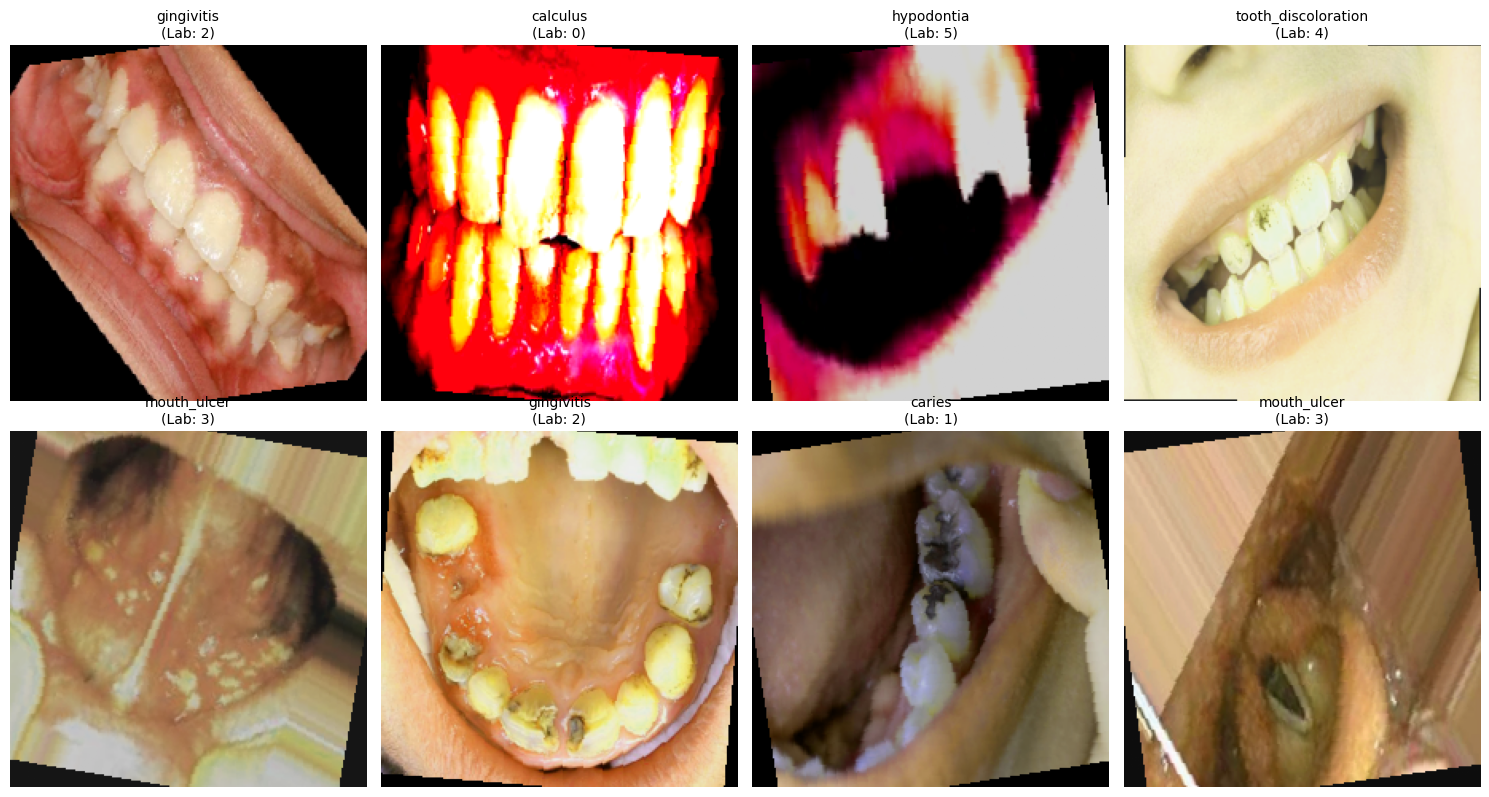

🖼️ Sample images from Validation DataLoader:


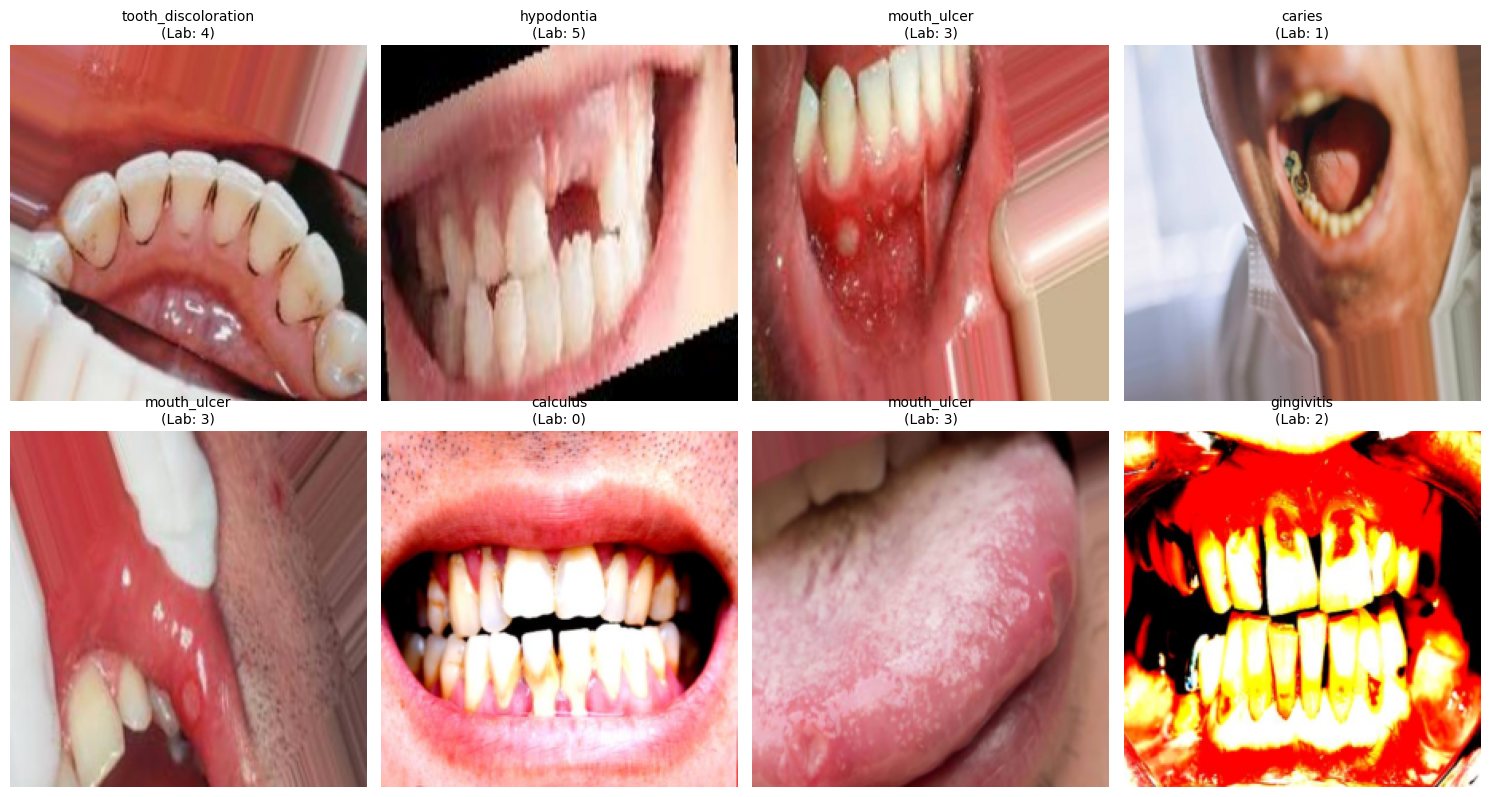

In [ ]:
def visualize_batch_samples(dataloader, class_names, num_images=8):
    """Visualize sample images from a DataLoader batch"""

    # Get one batch
    for images, labels, batch_class_names in dataloader:
        break

    # Denormalize for visualization
    def denormalize(tensor):
        mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
        tensor = tensor * std + mean
        tensor = torch.clamp(tensor, 0, 1)
        return tensor

    # Plot images
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.ravel()

    for i in range(min(num_images, len(images))):
        img = denormalize(images[i]).permute(1, 2, 0).numpy()
        label = labels[i].item()
        class_name = batch_class_names[i]

        axes[i].imshow(img)
        axes[i].set_title(f'{class_name}\n(Lab: {label})', fontsize=10)
        axes[i].axis('off')

    # Hide empty subplots
    for i in range(len(images), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    return images, labels

print("🖼️ Sample images from Training DataLoader (after transformations):")
train_images, train_labels = visualize_batch_samples(train_loader, class_names)

print("🖼️ Sample images from Validation DataLoader:")
val_images, val_labels = visualize_batch_samples(val_loader, class_names)

# Class Distribution Visualization

/tmp/ipython-input-3012758894.py:37: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3012758894.py:37: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3012758894.py:37: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3012758894.py:37: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_i

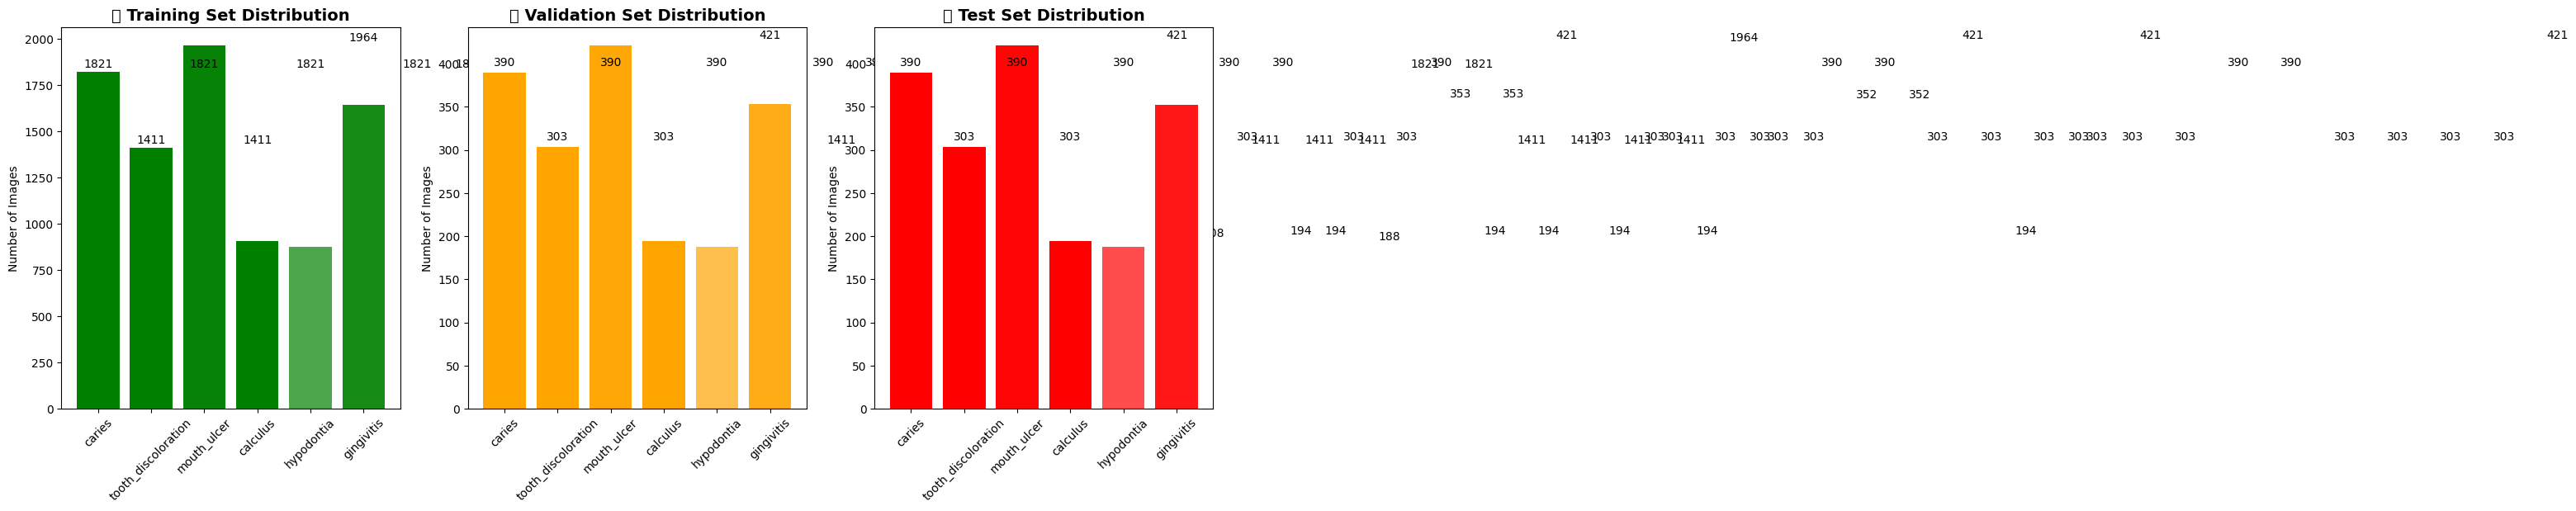

📊 CLASS DISTRIBUTION SUMMARY:
caries               | Train: 1821 | Val: 390 | Test: 390 | Total: 2601
tooth_discoloration  | Train: 1411 | Val: 303 | Test: 303 | Total: 2017
caries               | Train: 1821 | Val: 390 | Test: 390 | Total: 2601
tooth_discoloration  | Train: 1411 | Val: 303 | Test: 303 | Total: 2017
caries               | Train: 1821 | Val: 390 | Test: 390 | Total: 2601
mouth_ulcer          | Train: 1964 | Val: 421 | Test: 421 | Total: 2806
caries               | Train: 1821 | Val: 390 | Test: 390 | Total: 2601
caries               | Train: 1821 | Val: 390 | Test: 390 | Total: 2601
calculus             | Train:  908 | Val: 194 | Test: 194 | Total: 1296
hypodontia           | Train:  875 | Val: 188 | Test: 188 | Total: 1251
caries               | Train: 1821 | Val: 390 | Test: 390 | Total: 2601
calculus             | Train:  908 | Val: 194 | Test: 194 | Total: 1296
calculus             | Train:  908 | Val: 194 | Test: 194 | Total: 1296
tooth_discoloration  | Train: 1411

In [ ]:
def plot_class_distribution(train_df, val_df, test_df, class_names):
    """Plot class distribution across splits"""

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Training distribution
    train_counts = [len(train_df[train_df['class_name'] == cls]) for cls in class_names]
    axes[0].bar(class_names, train_counts, color='green', alpha=0.7)
    axes[0].set_title('🟢 Training Set Distribution', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Number of Images')
    axes[0].tick_params(axis='x', rotation=45)

    # Add count labels on bars
    for i, v in enumerate(train_counts):
        axes[0].text(i, v + 10, str(v), ha='center', va='bottom')

    # Validation distribution
    val_counts = [len(val_df[val_df['class_name'] == cls]) for cls in class_names]
    axes[1].bar(class_names, val_counts, color='orange', alpha=0.7)
    axes[1].set_title('🟡 Validation Set Distribution', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Number of Images')
    axes[1].tick_params(axis='x', rotation=45)

    for i, v in enumerate(val_counts):
        axes[1].text(i, v + 5, str(v), ha='center', va='bottom')

    # Test distribution
    test_counts = [len(test_df[test_df['class_name'] == cls]) for cls in class_names]
    axes[2].bar(class_names, test_counts, color='red', alpha=0.7)
    axes[2].set_title('🔴 Test Set Distribution', fontsize=14, fontweight='bold')
    axes[2].set_ylabel('Number of Images')
    axes[2].tick_params(axis='x', rotation=45)

    for i, v in enumerate(test_counts):
        axes[2].text(i, v + 5, str(v), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Print summary
    print("📊 CLASS DISTRIBUTION SUMMARY:")
    print("="*50)
    for cls in class_names:
        train_count = len(train_df[train_df['class_name'] == cls])
        val_count = len(val_df[val_df['class_name'] == cls])
        test_count = len(test_df[test_df['class_name'] == cls])
        total = train_count + val_count + test_count
        print(f"{cls:20} | Train: {train_count:4d} | Val: {val_count:3d} | Test: {test_count:3d} | Total: {total:4d}")

# Plot class distribution
plot_class_distribution(train_df, val_df, test_df, class_names)

**Plotting**

In [27]:
%matplotlib inline

In [28]:
def plot_comprehensive_training_history(history, test_accuracy):
    # Safety check
    if len(history['train_loss']) == 0:
        print("❌ No training history to plot!")
        return

    # Ensure test_accuracy is in percentage
    if test_accuracy <= 1.0:
        test_accuracy = test_accuracy * 100.0

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

    # Plot 1: Loss
    ax1.plot(history['train_loss'], label='Train Loss', linewidth=2, color='blue')
    ax1.plot(history['val_loss'], label='Val Loss', linewidth=2, color='red')
    ax1.set_title('📉 Training & Validation Loss', fontsize=16, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Accuracy
    ax2.plot(history['train_acc'], label='Train Accuracy', linewidth=2, color='green')
    ax2.plot(history['val_acc'], label='Val Accuracy', linewidth=2, color='orange')
    ax2.axhline(y=test_accuracy, color='purple', linestyle='--', linewidth=2,
                label=f'Test Accuracy ({test_accuracy:.2f}%)')
    ax2.set_title('📈 Training & Validation Accuracy', fontsize=16, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot 3: Gap
    train_val_gap = [t - v for t, v in zip(history['train_acc'], history['val_acc'])]
    ax3.plot(train_val_gap, linewidth=2, color='brown')
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax3.set_title('📊 Train-Validation Gap', fontsize=16, fontweight='bold')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Accuracy Gap (%)')
    ax3.grid(True, alpha=0.3)

    # Plot 4: Summary
    metrics = ['Train Acc', 'Val Acc', 'Test Acc']
    values = [history['train_acc'][-1], history['val_acc'][-1], test_accuracy]
    bars = ax4.bar(metrics, values, color=['green', 'orange', 'purple'], alpha=0.7)
    ax4.set_title('🎯 Final Performance Summary', fontsize=16, fontweight='bold')
    ax4.set_ylabel('Accuracy (%)')
    for bar, val in zip(bars, values):
        ax4.text(bar.get_x() + bar.get_width()/2., val + 0.5,
                f'{val:.2f}%', ha='center', va='bottom', fontweight='bold')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()  # 👈 MUST be called